In [2]:
import numpy as np
import pathlib as pl
import os
import pandas as pd
import warnings
warnings.simplefilter("ignore")
from copy import copy
import analysis.retroBO_analysis_functions as fns
import pickle
import matplotlib.pyplot as plt
import matplotlib as mpl

# mpl.style.use('mystyle.mplstyle')

inch_conversion = 1/25.4
page_width = 142.4 * inch_conversion
column_width = 67.2 * inch_conversion

# Notebook for Plotting Retrospective Bayesian Optimisation Results

This notebook is for plotting the results of the retrospective Bayesian optimisation on the PCR data.

First specify the problem

In [3]:
param_name = 'r' # which parameters
save=False
params = ['r']
starting_points = ['centre', '0_point_start']
learning_types = ['learning_many', 'learning_1']

Load the results

In [6]:
res_dfs = {}

results_path = pl.Path(os.getcwd()) / 'results' / 'unpenalized_bayes_opt'
for key in ['centre_learning_1', '0_point_start_learning_1',
                  'centre_learning_many', '0_point_start_learning_many']:
    res_dfs[key] = pd.read_csv(results_path / f'bayes_opt_{key}.csv', index_col=0)

Check what data is missing
If necessary, see which seeds are missing data:

In [7]:
for key, df in res_dfs.items():
    print(key)
    counts_df = pd.DataFrame(columns=res_dfs[f'centre_learning_many']['PrimerPairReporter'].unique())
    for ppr in df['PrimerPairReporter'].unique():
        df_ = df[df['PrimerPairReporter'] == ppr][['BP', 'GC', 'seed']].drop_duplicates()
        counts = df_.value_counts('seed').to_frame().sort_values(by='seed')
        counts_df[ppr] = df_.value_counts('seed').to_frame().sort_values(by='seed')
        # seeds_df[key][ppr] = len(df_['seed'].unique())
    print(counts_df.T.to_string())

centre_learning_1
seed                   0   1   2   3   4   5   6   7   8   9   10  11  12  13  14  15  16  17  18  19  20  21  22  23  24
FP001-RP001x-EvaGreen  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24  24
FP002-RP002x-EvaGreen  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15  15
FP005-FP001-Probe       8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
RP001x-FP002-Probe     19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19  19
RP002x-FP005-Probe      8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
FP005-FP004-EvaGreen    8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8   8
FP004-RP004-Probe      47  49  49  47  49  49  53  46  49  46  47  49  38  47  41  47  47  46  39  47  53  47  46  43  47
RP002x

Calculate the regret

In [8]:
stzd = True
max_iter = 16

if len(params) >1:
    regret_metric = 'combined regret'
else:
    if param_name == 'r':
        regret_metric = 'regret r'
    elif param_name == 'm':
        regret_metric = 'regret m'

starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Learning Many', 'learning_1':'Learning One\nat a Time'}
plot_minmax = True

regrets_all = {'learning_many':{}, 'learning_1':{}}
for i, learning_type in enumerate(learning_types): #, 'learning 1'
    for j, starting_point in enumerate(starting_points):
        df = res_dfs[f'{starting_point}_{learning_type}']
        best_points = fns.get_best_points(params, df, stzd=stzd, log_t=False)
        regret_df_all = fns.calculate_regret(df, params, best_points, stzd=stzd)
        regret_df_all = regret_df_all[regret_df_all['iteration'] <=max_iter]
        regrets_all[learning_type][starting_point] = regret_df_all

In [9]:

cumulative_regrets = {'learning_many':{},
                      'learning_1':{}}
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regrets_all[learning_type][starting_point]

        if 'r' in params and 'm' in params:
            regret_names = ['combined regret', 'regret r', 'regret m']
        else:
            regret_names = [f'regret {param}' for param in params]

        # if learning_type == 'learning many':
        #     for seed in regret_df['seed'].unique():
        #         temp_df = regret_df[regret_df['seed'] == seed]
        #         if temp_df['iteration'].max() != max_iter:
        #             regret_df= regret_df[regret_df['seed'] != seed]

        regret_df = regret_df.sort_values('iteration')

        # calculate the cumulative minimum regret and cumulative sum of regret

        for model in regret_df['model'].unique():
            for seed in regret_df['seed'].unique():
                for ppr in regret_df['PrimerPairReporter'].unique():
                    for regret_name in regret_names:
                        regret_df.loc[
                            (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                        regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'] = \
                            regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), regret_name].cummin()
                        regret_df.loc[
                            (regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                        regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cumsum'] = \
                            regret_df.loc[(regret_df['model'] == model) & (regret_df['seed'] == seed) & (
                                    regret_df['PrimerPairReporter'] == ppr), f'{regret_name} cummin'].cumsum()
        cumulative_regrets[learning_type][starting_point] = regret_df

In [10]:
regret_metrics = {'learning_many':{}, 'learning_1':{}}
for i, learning_type in enumerate(learning_types): #, 'learning 1'
    for j, starting_point in enumerate(starting_points):
        regret_df = cumulative_regrets[learning_type][starting_point]

        i_max = regret_df['iteration'].max() #.loc[regret_df['model'] =='avg',

        for ppr in regret_df['PrimerPairReporter'].unique():

            ppr_imax = regret_df.loc[regret_df['PrimerPairReporter'] == ppr, 'iteration'].to_numpy().max()
            if ppr_imax == i_max:
                pass
            else:
                extra_rows = pd.concat([regret_df.loc[(regret_df['PrimerPairReporter'] == ppr)
                                                & (regret_df['iteration'] == ppr_imax)]] * int((i_max - ppr_imax)))
                extra_rows = extra_rows.sort_values(['model', 'seed'])
                if ppr_imax < (i_max - 1):
                    test = np.arange(ppr_imax + 1, i_max + 1).tolist() * int(len(extra_rows)/(i_max-ppr_imax))
                    extra_rows['iteration'] = np.arange(ppr_imax + 1, i_max + 1).tolist() \
                                              * int(len(extra_rows)/(i_max-ppr_imax))
                    regret_df = regret_df.append(extra_rows)
                elif ppr_imax == (i_max - 1):
                    extra_rows['iteration'] = i_max
                    regret_df = regret_df.append(extra_rows)
                else:
                    pass
        # if learning_type == 'learning many':
        df = regret_df.groupby(['model', 'iteration', 'seed']).mean().reset_index()

        df2 = df.groupby(['model', 'iteration']).mean().reset_index()
        df3 = df.groupby(['model', 'iteration']).median().reset_index()
        df4 = df.groupby(['model', 'iteration']).quantile(0.05).reset_index()
        df5 = df.groupby(['model', 'iteration']).quantile(0.95).reset_index()
        metrics = ['mean', 'median', 'min', 'max']

        dfs = [df2, df3, df4, df5]
        for i in range(len(dfs)):
            for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
                dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
            dfs[i] = dfs[i].drop(
                columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
                        + ['seed', 'index', 'initial_surface'] + regret_names)
        regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration'])
        regret_df = regret_df.merge(dfs[2], on=['model', 'iteration'])
        regret_df = regret_df.merge(dfs[3], on=['model', 'iteration'])

        # else:
        #
        #     # calculate the mean, min, and max of the cumulative minimum regret and cumulative sum of
        #     # regret across all seeds for each primer pair reporter
        #
        #     df4 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).mean().reset_index()
        #     df7 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).median().reset_index()
        #     df5 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).min().reset_index()
        #     df6 = regret_df.groupby(['model', 'iteration', 'PrimerPairReporter']).max().reset_index()
        #
        #     # create new dataframe which combines these metrics
        #
        #     metrics = ['mean', 'min', 'max', 'median']
        #     dfs = [df4, df5, df6, df7]
        #     for i in range(len(dfs)):
        #         for col in [f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]:
        #             dfs[i][f'{metrics[i]} {col}'] = dfs[i][col]
        #         dfs[i] = dfs[i].drop(
        #             columns=[f'{regret_name} {met}' for regret_name in regret_names for met in ['cummin', 'cumsum']]
        #                     + ['seed', 'index', 'initial_surface'] + regret_names)
        #
        #     regret_df = dfs[0].merge(dfs[1], on=['model', 'iteration', 'PrimerPairReporter'])
        #     regret_df = regret_df.merge(dfs[2], on=['model', 'iteration', 'PrimerPairReporter'])
        #     regret_df = regret_df.merge(dfs[3], on=['model', 'iteration', 'PrimerPairReporter'])


        regret_df = regret_df.groupby(['model', 'iteration']).mean().reset_index()
        regret_metrics[learning_type][starting_point] = regret_df


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


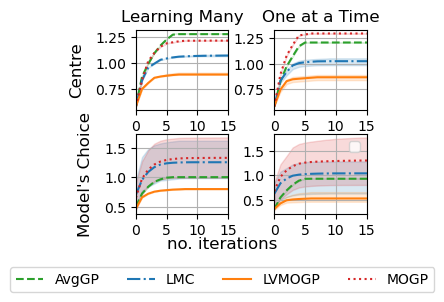

In [41]:

linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed' }

colors = fns.get_colors()
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Learning Many', 'learning_1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[0.6*page_width, 0.4*page_width])
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regret_metrics[learning_type][starting_point]
        for model in regret_df['model'].unique():
            df = regret_df[(regret_df['model'] == model)].sort_values('iteration')
            if (j==0) & (i==0):
                label = labels[model]
            else:
                label = None
            axs[j, i].plot(df['iteration'], df[f'mean {regret_metric} cumsum'], label=label,
                           color=colors[model], linestyle=linestyles[model])
            if plot_minmax:
                axs[j, i].fill_between(df['iteration'], df[f'min {regret_metric} cumsum'],
                                       df[f'max {regret_metric} cumsum'],
                                       alpha=0.17, color=colors[model])
        axs[0, i].set_title(f'{learning_type_names[learning_type]}')
        # axs[j, i].set_ylabel(f'Cum. Regret')
        axs[j, i].set_xlabel(None)
        axs[j, 1].set_ylabel(None)
        axs[j, i].set_xticks([0, 5, 10, 15] )
        axs[j, i].grid()

        axs[j, i].set_xlim(0, 15)



fig.legend(loc="lower center", ncols=4,
               bbox_to_anchor=(0.5, -0.2))


rows = [f'{row}' for row in starting_point_names.values()]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center', rotation=90)
    # plt.suptitle('Cumulative Regret')
    axs[j, i].legend()



plt.tight_layout()
fig.supxlabel('no. iterations')
plt.subplots_adjust(hspace=0.3, wspace=0.5, left=None, bottom=0.18, right=None, top=1)
# plt.tight_layout()
# plt.savefig(f'plots/retroBO_cumulative_regret_{param_name}_half_wlines.pdf', bbox_inches='tight')
# plt.savefig(f'plots/retroBO_cumulative_regret_{param_name}_half_wlines.svg', bbox_inches='tight')

In [ ]:
print(regret_metrics['learning_many']['centre'].groupby(['iteration', 'model']).mean().to_string())

#MC
# 1.00 1.63 0.80 1.69 LM 
# 0.93 1.29 0.66 1.78 L1



#cetnre
## 1.20 1.05 0.89 1.29
## 1.2 1.08 0.91 1.21


                       BP_x      GC_x       r_x  stzd r_x    r_mu_x  r_sig2_x  r_mu_z_x  r_sig2_z_x    EI_z_x  target r_x  target r z_x  error r_x  error from target r z_x  error from target r_x  error r z_x  error from optimization target z_x  diff from target r_x  best diff r_x  mean regret r cummin  mean regret r cumsum      BP_y      GC_y       r_y  stzd r_y    r_mu_y  r_sig2_y  r_mu_z_y  r_sig2_z_y    EI_z_y  target r_y  target r z_y  error r_y  error from target r z_y  error from target r_y  error r z_y  error from optimization target z_y  diff from target r_y  best diff r_y  median regret r cummin  median regret r cumsum      BP_x      GC_x       r_x  stzd r_x    r_mu_x  r_sig2_x  r_mu_z_x  r_sig2_z_x    EI_z_x  target r_x  target r z_x  error r_x  error from target r z_x  error from target r_x  error r z_x  error from optimization target z_x  diff from target r_x  best diff r_x  min regret r cummin  min regret r cumsum      BP_y      GC_y       r_y  stzd r_y    r_mu_y  r_sig2_y

In [ ]:
win_dfs = {}
for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):
        df = res_dfs[f'{starting_point}_{learning_type}']
        best_points = fns.get_best_points(params, df, stzd=stzd, log_t=False)
        regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd)
        regret_df1 =regret_df1[regret_df1['iteration']<= max_iter]
        win_df, win_df_totals = fns.get_win_counts(regret_df1, regret_metric)
        win_df_cum_regret, win_df_totals_cum_regret = fns.get_cum_regret_table(regret_df1, regret_name=regret_metric)
        win_dfs[learning_type + starting_point] = win_df
        print(learning_type, starting_point)
        print('first to zero')
        print(win_df_totals[['avg', 'mo_indi', 'lmc', 'lvm']])
        print('lowest cumulative regret')
        print(win_df_totals_cum_regret[['avg', 'mo_indi', 'lmc', 'lvm']])

learning_many centre
first to zero
   avg mo_indi  lmc  lvm
0  121     124  144  255
lowest cumulative regret
  avg mo_indi  lmc  lvm
0  80     182  140  197
learning_many 0_point_start
first to zero
   avg mo_indi lmc  lvm
0  119     107  97  147
lowest cumulative regret
  avg mo_indi lmc  lvm
0  94      85  83  117
learning_1 centre
first to zero
   avg mo_indi  lmc  lvm
0  140     140  156  215
lowest cumulative regret
   avg mo_indi  lmc  lvm
0  140     129  131  206
learning_1 0_point_start
first to zero
   avg mo_indi lmc  lvm
0  118      86  87  191
lowest cumulative regret
   avg mo_indi lmc  lvm
0  106      89  87  159


Average number of iterations to best best_points

In [152]:
import math

if len(params) >1:
    regret_metric = 'combined regret'
else:
    regret_metric = 'regret r'
win_dfs = {}
win_dfs_cum_regrets = {}
# for i, learning_type in enumerate(['learning many', 'learning 1']):
#     for j, starting_point in enumerate(starting_points):
zero_regret_dicts = {name: {} for name in res_dfs.keys()}
for name, df in res_dfs.items():
    best_points = fns.get_best_points(params, df, stzd=stzd, log_t=False)
    regret_df1 = fns.calculate_regret(df, params, best_points, stzd=stzd, penalized=False)
    # regret_df1 =regret_df1[regret_df1['iteration']<= max_iter]

    df = regret_df1
    avg_iter_df = pd.DataFrame(columns=['PrimerPairReporter'] + list(df['model'].unique()))
    avg_iter_df['PrimerPairReporter'] = df['PrimerPairReporter'].unique()
    for ppr in df['PrimerPairReporter'].unique():
        zero_regret_dict = {model:[] for model in df['model'].unique()}
        for seed in range(1, 25):
            temp_df = df[(df['PrimerPairReporter'] == ppr) & (df['seed'] == seed)]
            if len(temp_df) < 1:
                pass
            else:
                for model in temp_df['model'].unique():
                    temp_1 = temp_df[(temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8)]
                    temp_2 = temp_df[(temp_df['model'] == model) & (temp_df['regret r'] <= 0.05)]
                    # temp_1 = temp_df.loc[(temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8), 'iteration']
                    # temp_2 = temp_df.loc[(temp_df['model'] == model) & (temp_df['regret r'] <= 0.06)
                    #                      & (temp_df['regret m'] < 1e-8), 'iteration']
                    temp_3 = pd.concat([temp_1, temp_2])
                    zero_regret_dict[model].append(np.min(temp_3['iteration']))
        zero_regret_dicts[name][ppr] = zero_regret_dict


                    # zero_regret_dict[model].append(np.min(
                    #     temp_df.loc[((temp_df['model'] == model) & (temp_df[regret_metric] <= 1e-8)).all() or
                    #                 ((temp_df['model'] == model) & (temp_df['regret r'] <= 0.06)
                    #                & (temp_df['regret m'] < 1e-8)).all(), 'iteration']))
        # for model in temp_df['model'].unique():
            # zero_regret_dict[model] = [max_iter if math.isnan(x) else x for x in zero_regret_dict[model]]
        for model in df['model'].unique():
            if np.isnan(zero_regret_dict[model]).any():
                print(f'{name} {ppr} {model} has NaNs')
            avg_iter_df.loc[avg_iter_df['PrimerPairReporter'] == ppr, model] = np.mean(zero_regret_dict[model])

    print(name)
    print(avg_iter_df)

    print(avg_iter_df.mean())


centre_learning_1
       PrimerPairReporter  avg       lmc       lvm mo_indi
0   FP001-RP001x-EvaGreen  5.0  8.333333       2.0     3.0
1      FP001-RP001x-Probe  5.0       6.5       8.0     7.0
2    FP001-RP004-EvaGreen  6.0       3.5     1.875     5.0
3   FP002-RP002x-EvaGreen  1.0     3.375     1.875     1.0
4    FP002-RP004-EvaGreen  1.0       1.0     1.125     1.0
5       FP004-FP005-Probe  1.0       5.0     2.875     4.0
6       FP004-RP004-Probe  2.0      2.25       2.0     3.0
7    FP005-FP001-EvaGreen  2.0  1.833333  1.583333     1.0
8       FP005-FP001-Probe  6.0  4.083333  4.083333     2.0
9    FP005-FP004-EvaGreen  0.0       0.0       0.0     0.0
10     RP001x-FP002-Probe  5.0       1.0       1.0     7.0
11  RP002x-FP002-EvaGreen  1.0       1.0       1.0     1.0
12  RP002x-FP004-EvaGreen  3.0  1.833333       1.0     2.0
13     RP002x-FP005-Probe  0.0       0.0       0.0     0.0
14  RP008x-FP001-EvaGreen  5.0       2.0  2.958333     5.0
15     RP008x-FP005-Probe  6.0       4

IndentationError: expected an indented block (935393101.py, line 4)

In [75]:
zero_regret_dicts.keys()

dict_keys(['centre_learning_1', '0_point_start_learning_1', 'centre_learning_many', '0_point_start_learning_many'])

In [145]:
totals = {'avg': [], 'mo_indi': [], 'lmc': [], 'lvm':[]}
totals_dfs = []

for name, dict1 in zero_regret_dicts.items():
    for ppr, dict2 in dict1.items():
        for model_name, iters_list in dict2.items():
            totals[model_name] = totals[model_name] + iters_list
            for i in range(len(iters_list)):
                new_df = pd.DataFrame.from_dict({'test_type':[name], 'model': [model_name], 'seed':[i], 'iteration':[iters_list[i]], 'PrimerPairReporter': [ppr]})
                totals_dfs.append(new_df)

total_df = pd.concat(totals_dfs)

In [151]:
print(total_df.groupby(['test_type', 'model']).mean())

                                     seed  iteration
test_type                   model                   
0_point_start_learning_1    avg      11.5   2.625000
                            lmc      11.5   2.648438
                            lvm      11.5   1.825521
                            mo_indi  11.5   2.914062
0_point_start_learning_many avg      11.5   2.625000
                            lmc      11.5   3.096354
                            lvm      11.5   2.437500
                            mo_indi  11.5   3.109375
centre_learning_1           avg      11.5   3.062500
                            lmc      11.5   2.856771
                            lvm      11.5   2.148438
                            mo_indi  11.5   2.937500
centre_learning_many        avg      11.5   3.250000
                            lmc      11.5   3.117188
                            lvm      11.5   2.578125
                            mo_indi  11.5   3.125000


In [153]:
total_df.groupby(['model']).mean().reset_index()

,model,seed,iteration
0,avg,11.5,2.890625
1,lmc,11.5,2.929688
2,lvm,11.5,2.247396
3,mo_indi,11.5,3.021484


In [155]:
3.021484*16

48.343744

In [78]:
max_iters_df = total_df.groupby([ 'model']).sum().reset_index()
print(max_iters_df.to_string())


     model   seed  iteration
0      avg  17664     4440.0
1      lmc  17664     4500.0
2      lvm  17664     3452.0
3  mo_indi  17664     4641.0


In [79]:
for model_name, total_list in totals.items():
    print(model_name, np.mean(total_list))

avg 2.890625
mo_indi 3.021484375
lmc 2.9296875
lvm 2.2473958333333335


In [87]:
for model_name, total_list in totals.items():
    print(model_name, np.sum(total_list)/(24*16*4))

avg 2.890625
mo_indi 3.021484375
lmc 2.9296875
lvm 2.2473958333333335


centre_learning_many
0_point_start_learning_many
centre_learning_1
0_point_start_learning_1


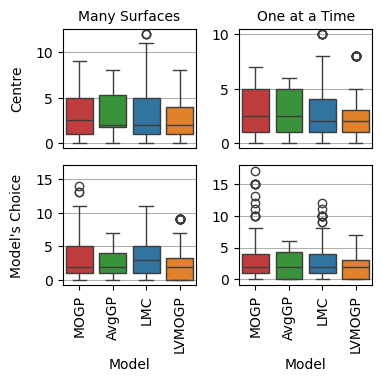

In [144]:
import seaborn as sns
linestyles = {'lmc':'dashdot', 'mo_indi': 'dotted', 'lvm':  'solid' , 'avg': 'dashed'}

labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}
total_df['model_label'] = total_df['model'].map(labels)


total_df['order'] = total_df['model'].map({'mo_indi':1, 'avg':2, 'lmc':3, 'lvm':4})
total_df = total_df.sort_values('order')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=[0.7*page_width, 0.7*page_width])
colors = fns.get_colors()
plot_minmax=True
starting_point_names = {'centre':'Centre', '0_point_start':'Model\'s Choice'}
learning_type_names = {'learning_many':'Many Surfaces', 'learning_1':'One at a Time'}
labels = {'mo_indi':'MOGP', 'avg':'AvgGP', 'lmc': 'LMC', 'lvm':'LVMOGP'}

keys_list = total_df['test_type'].unique()

for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        name = [s for s in keys_list if learning_type in s and starting_point in s][0]
        print(name)
         
        data = totals
        # Convert the data dictionary into a DataFrame
        df = total_df[total_df['test_type'] == name]

        # Create a color palette based on the color_map dictionary
        palette = [colors[category] for category in df['model'].unique()]

        # Create the boxplot using seaborn
        sns.boxplot(x='model_label', y='iteration', data=df, palette=palette, ax=axs[j, i])
        axs[j,i].tick_params(axis='x', rotation=90)
        # axs[j,i].set_xticks(axs[j,i].get_xticklabels(), rotation=30, ha='right')
        # for label in axs[j,i].get_xticklabels():
        #     label.set_rotation(30)
        #     label.set_ha('right')


        if starting_point == 'centre':
            axs[j,i].set_title(f'{learning_type_names[learning_type]}', fontsize=10)

        # Customize the plot
        # ax.set_title(f'{name}')
        axs[0,i].set_xticklabels('')
        axs[0,i].set_xticks([])

        axs[0,i].set_xlabel('')
        axs[1,i].set_xlabel('Model')
        axs[j,i].set_ylabel('')

    


rows = [f'{row}' for row in starting_point_names.values()]
for ax, row in zip(axs[:,0], rows):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                fontsize=10, ha='right', va='center', rotation=90)
    
for ax in axs.flatten():
    ax.grid(axis='y')
    # ax.set_ylim(None, 15.5)
axs[1,0].set_ylim(None, 17)


plt.tight_layout()
plot_path = pl.Path(os.getcwd()) / 'analysis/plots'
plt.savefig(plot_path / f'retroBO_no_experiments_boxplot_unpenalized.svg', bbox_inches='tight')

In [ ]:
avg_iter_df

,PrimerPairReporter,avg,lmc,lvm,mo_indi
0,FP001-RP001x-EvaGreen,7.0,7.45,5.0,5.6
1,FP001-RP001x-Probe,6.0,5.35,7.0,6.0
2,FP001-RP004-EvaGreen,0.0,3.2,0.0,4.1
3,FP002-RP002x-EvaGreen,3.0,3.9,3.0,5.5
4,FP002-RP004-EvaGreen,0.0,0.75,2.0,0.7
5,FP004-FP005-Probe,4.0,4.0,3.0,3.55
6,FP004-RP004-Probe,1.0,3.55,9.0,2.3
7,FP005-FP001-EvaGreen,3.0,4.2,0.0,3.3
8,FP005-FP001-Probe,6.0,2.95,1.0,1.1
9,FP005-FP004-EvaGreen,1.0,1.25,0.0,1.95


In [ ]:
zero_regret_dicts.keys()

dict_keys(['centre_learning_1', '0_point_start_learning_1', 'centre_learning_many', '0_point_start_learning_many'])

In [ ]:
zero_regret_dicts['0_point_start_learning_many']

{'FP001-RP001x-EvaGreen': {'avg': [7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7,
   7],
  'lmc': [7, 9, 5, 10, 6, 11, 6, 7, 6, 10, 7, 10, 9, 9, 2, 9, 9, 8, 3, 6],
  'lvm': [5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5],
  'mo_indi': [2, 3, 13, 2, 4, 9, 8, 2, 4, 4, 2, 14, 4, 1, 2, 13, 5, 4, 8, 8]},
 'FP001-RP001x-Probe': {'avg': [6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6,
   6],
  'lmc': [8, 6, 2, 6, 9, 6, 2, 7, 4, 7, 7, 5, 2, 0, 4, 6, 5, 7, 7, 7],
  'lvm': [7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7],
  'mo_indi': [8, 1, 6, 8, 6, 0, 6, 9, 2, 8, 9, 11, 8, 9, 9, 2, 1, 2, 6, 9]},
 'FP001-RP004-EvaGreen': {'avg': [0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0,
   0],
  'lmc': [0, 1, 5, 4, 6, 5, 3, 1, 1, 6, 6, 4, 0, 1, 6, 1, 1, 6, 6, 1],
  'lvm': [0, 0, 0, 0, 0, 0, 0,

In [ ]:
first_regret_df = pd.DataFrame(columns=['model', 'starting point','learning type', 'mean', 'min', 'max'])
first_regret_df['model'] = ['avg', 'mo_indi', 'lmc', 'lvm'] * 4
first_regret_df['starting point'] = ['centre'] * 4 + ['0_point_start'] * 4 + ['centre'] * 4 + ['0_point_start'] * 4
first_regret_df['learning type'] = ['learning many'] * 8 + ['learning 1'] * 8
dfs = []

for i, learning_type in enumerate(learning_types):
    for j, starting_point in enumerate(starting_points):

        regret_df = regret_metrics[learning_type][starting_point]
        for mod_name in regret_df['model'].unique():
            df_ = regret_df[(regret_df['model'] == mod_name) & (regret_df['iteration'] == np.min(regret_df['iteration']))]
            new_df = pd.DataFrame(data=[[mod_name, starting_point, learning_type , df_['median regret r cummin'].to_numpy()[0],
                                         df_['min regret r cummin'].to_numpy()[0],
                                         df_['max regret r cummin'].to_numpy()[0] ]],
                                  columns=['model', 'starting point','learning type', 'mean', 'min', 'max'])
            dfs.append(new_df)

first_regret_df = pd.concat(dfs, ignore_index=True)
print(first_regret_df.to_string())
print('lvm only:')
print(first_regret_df[first_regret_df['model']== 'lvm'].to_string())

      model starting point  learning type      mean       min       max
0       avg         centre  learning_many  0.587843  0.587843  0.587843
1       lmc         centre  learning_many  0.587843  0.587843  0.587843
2       lvm         centre  learning_many  0.587843  0.587843  0.587843
3   mo_indi         centre  learning_many  0.587843  0.587843  0.587843
4       avg  0_point_start  learning_many  0.498869  0.498869  0.498869
5       lmc  0_point_start  learning_many  0.674284  0.522551  0.953738
6       lvm  0_point_start  learning_many  0.463846  0.463846  0.463846
7   mo_indi  0_point_start  learning_many  0.643405  0.439144  0.905719
8       avg         centre     learning_1  0.587843  0.587843  0.587843
9       lmc         centre     learning_1  0.587843  0.587843  0.587843
10      lvm         centre     learning_1  0.587843  0.587843  0.587843
11  mo_indi         centre     learning_1  0.587843  0.587843  0.587843
12      avg  0_point_start     learning_1  0.307999  0.307999  0